# WNTR Model Development Tutorial

The following tutorial illustrates how to generate water distribution system models from perfect and imperfect geospatial data. The ky4 model is used as the basis of this tutorial, and is used to create the "perfect" geospatial data which accuratly reflects junctions, tanks, reservoirs, pipes, and pumps in the model.  The "imperfect" geospatial data was generated by truncating, skewing, and omitting certain aspects of the perfect datasets. 

Note that additional attributes not contained in geospatial data (i.e., controls, patterns, simulation options) are also added to the model to replicate conditions in ky4.

The following demo contains three WaterNetworkModels:
- wn0 is the base model
- wn1 is a model built from perfect geospatial data
- wn2 is a model built from imperfect geospatial data

In [1]:
# The following defines coordinates used to zoom in on network graphics
zoom_coords = [(4978500, 4982000), (3903000, 3905500)] 

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Geopandas is used to load geospatial data
- NetworkX is used to compute distances on the network
- Matplotlib is used to create subplots

In [2]:
## Imports
import geopandas as gpd
import networkx as nx
from shapely import LineString
import matplotlib.pylab as plt
import wntr

crs = "EPSG:3547"  # ft

# Create a base model from the INP file (wn0)

In [3]:
wn0 = wntr.network.WaterNetworkModel("../networks/ky4.inp")

## Run a hydraulic simulation and compute metrics
Compute pressure and average expected demand for use in later comparisons with wn1 and wn2

In [4]:
sim = wntr.sim.EpanetSimulator(wn0)
results0 = sim.run_sim()
pressure0 = results0.node["pressure"].loc[0, :]
pressure0[pressure0<0] = 0 # remove negative pressure
aed0 = wntr.metrics.average_expected_demand(wn0)

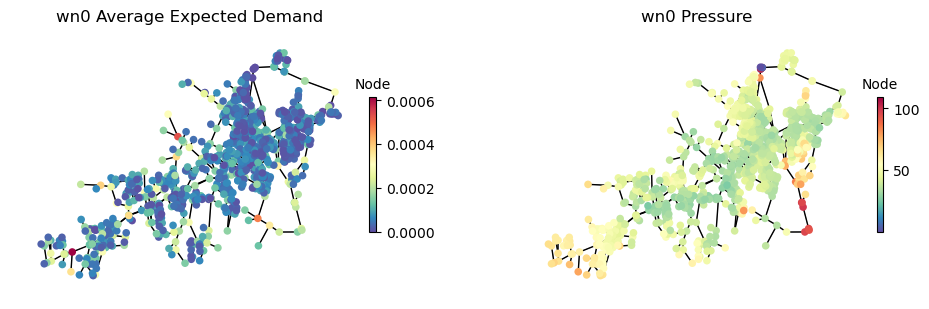

In [5]:
# Plot metrics
fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn0, node_attribute=aed0, node_size=30, title="wn0 Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn0, node_attribute=pressure0, node_size=30, title="wn0 Pressure", show_plot=False, ax=axes[1])

## Create perfect geospatial data
Perfect geospatial data is used to create wn1.

In [6]:
wntr.network.io.write_geojson(wn0, "../data/ky4", crs=crs)

# Create a model from perfect geospatial data (wn1)
The following section creates base `WaterNetworkModel` object from perfect geospatial data.  Information not included in geospatial data (i.e., controls, patterns, initial status, simulation options) are then added to the model.

## Add geospatial data

The GeoJSON files contain complete attributes for junctions, tanks, reservoirs, pipes, and pumps.  

In [7]:
geojson_files = {
    "junctions": "../data/ky4_junctions.geojson",
    "tanks": "../data/ky4_tanks.geojson",
    "reservoirs": "../data/ky4_reservoirs.geojson",
    "pipes": "../data/ky4_pipes.geojson",
    "pumps": "../data/ky4_pumps.geojson",
}

wn1 = wntr.network.read_geojson(geojson_files)

## Add controls

In [8]:
line = "LINK ~@Pump-1 OPEN IF NODE T-3 BELOW  27.6606"  # 90.75 ft
wn1.add_control("Pump1_open", line)

line = "LINK ~@Pump-1 CLOSED IF NODE T-3 ABOVE  32.2326"  # 105.75 ft
wn1.add_control("Pump1_closed", line)

## Add a demand pattern

In [9]:
multipliers = [
    0.33, 0.25, 0.209, 0.209, 0.259, 0.36,
    0.529, 0.91, 1.2, 1.299, 1.34, 1.34,
    1.32, 1.269, 1.25, 1.25, 1.279, 1.37,
    1.519, 1.7, 1.75, 1.669, 0.899, 0.479,
]
default_pattern_name = wn1.options.hydraulic.pattern
wn1.add_pattern(default_pattern_name, multipliers)

## Add pump initial status

In [10]:
pump = wn1.get_link("~@Pump-1")
pump.initial_status = "Closed"

## Run a hydraulic simulation and compute metrics

In [11]:
sim = wntr.sim.EpanetSimulator(wn1)
results1 = sim.run_sim()

pressure1 = results1.node["pressure"].loc[0, :]
pressure1[pressure1<0] = 0 # remove negative pressure
aed1 = wntr.metrics.average_expected_demand(wn1)

## Compare the base model to the model created from perfect geospatial data
Compare number of components and the difference in average expected demand and pressure

In [12]:
print(wn0.describe())
print(wn1.describe())

{'Nodes': 964, 'Links': 1158, 'Patterns': 3, 'Curves': 0, 'Sources': 0, 'Controls': 2}
{'Nodes': 964, 'Links': 1158, 'Patterns': 1, 'Curves': 0, 'Sources': 0, 'Controls': 2}


In [13]:
# Compute absolute difference in average expected demand and pressure
aed_diff1 = (aed0 - aed1).abs()
pressure_diff1 = (pressure0 - pressure1).abs()

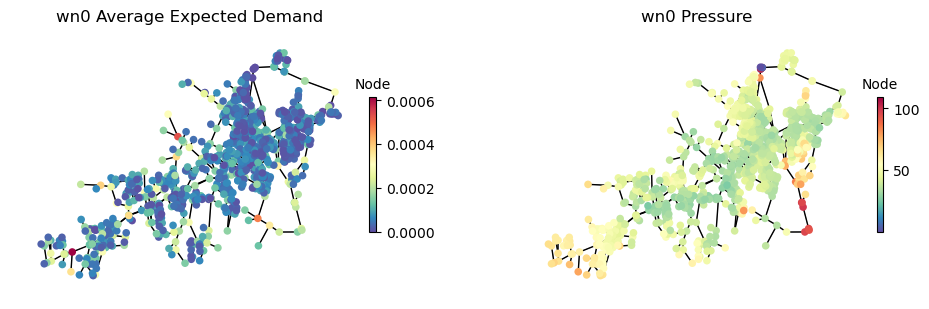

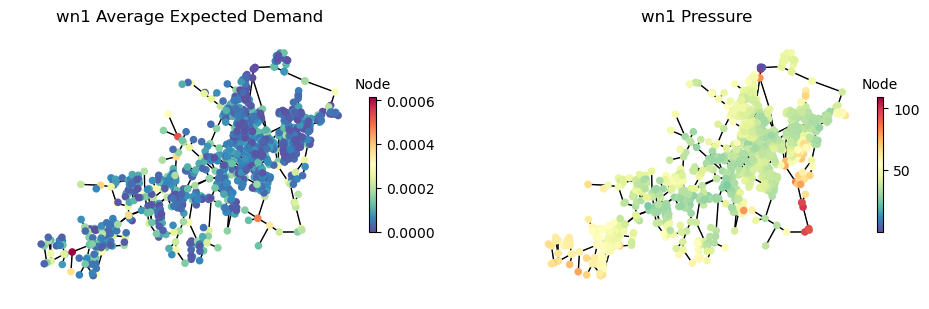

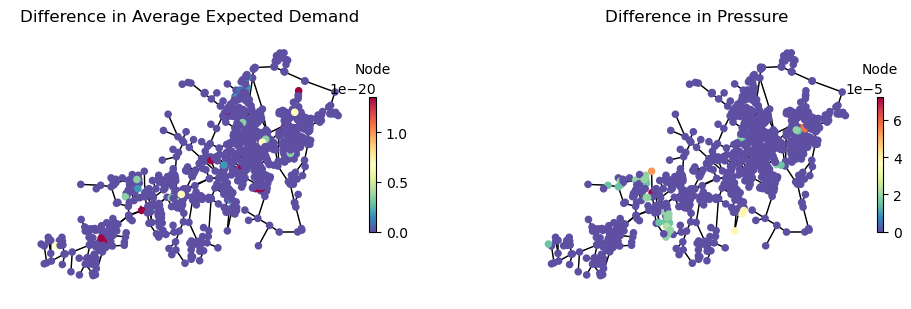

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn0, node_attribute=aed0, node_size=30, title="wn0 Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn0, node_attribute=pressure0, node_size=30, title="wn0 Pressure", show_plot=False, ax=axes[1])

fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn1, node_attribute=aed1, node_size=30, title="wn1 Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn1, node_attribute=pressure1, node_size=30, title="wn1 Pressure", show_plot=False, ax=axes[1])

fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn1, node_attribute=aed_diff1, node_size=30, title="Difference in Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn1, node_attribute=pressure_diff1, node_size=30, title="Difference in Pressure", show_plot=False, ax=axes[1])

In [15]:
# Assert that difference is small
print(aed_diff1.mean(), pressure_diff1.mean())
assert (aed_diff1.mean() < 1e-3), "Average expected demand difference is greater that tolerance"
assert (pressure_diff1.mean() < 1e-3), "Pressure difference is greater that tolerance"

2.7910574695762137e-22 1.3058611e-06


In [16]:
aed_diff1_mean = abs(aed0.mean() - aed1.mean())
pressure_diff1_mean = abs(pressure0.mean() - pressure1.mean())
print(aed_diff1_mean, pressure_diff1_mean)

0.0 0.0


# Create a model from imperfect geospatial data (wn2)

The following inperfections are included in the following geospatial data
1. Junction data does not exist (no elevation, demand, or coordinates)
2. Pipe data has endpoints that do not align, the pipe data also does not contain start and end node names
3. Pump data does not contain start and end node names

Tank and reservoir is complete but needs to be associated with the nearest node

## Refine the geospatial data

### Load data

In [17]:
diconnected_pipes = gpd.read_file("../data/ky4_disconnected_pipes.geojson", crs=crs)
disconnected_pumps = gpd.read_file("../data/ky4_disconnected_pumps.geojson", crs=crs)
tanks = gpd.read_file("../data/ky4_tanks.geojson", crs=crs)
reservoirs = gpd.read_file("../data/ky4_reservoirs.geojson", crs=crs)

diconnected_pipes.set_index("name", inplace=True)
disconnected_pumps.set_index("name", inplace=True)
tanks.set_index("name", inplace=True)
reservoirs.set_index("name", inplace=True)

# Assume that total demand is known
total_demand = aed0.sum()

# Additional datasets include elevation data and building data
elevation_data_file = '../data/ky4_elevation.tif' 

buildings = gpd.read_file("../data/ky4_buildings.geojson", crs=crs)
buildings.to_crs(crs, inplace=True)

C:\Users\kaklise\AppData\Local\Temp\ipykernel_33536\1723416545.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


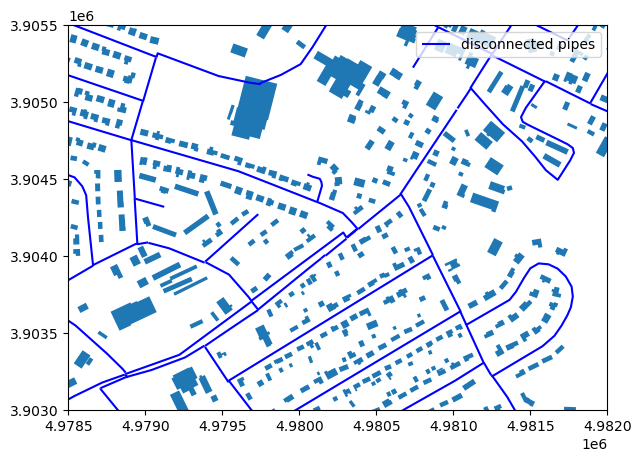

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
diconnected_pipes.plot(color="b", label='disconnected pipes', ax=ax)
buildings.plot(label='buildings', ax=ax)
ax.legend()
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

### Connect pipes and define junctions

Number of diconnected pipes 1156
Number of connected pipes 1148
       CV  diameter status      length  minor_loss  roughness  \
name                                                            
P-1     0    0.1524   Open  536.487929         0.0      150.0   
P-10    0    0.2032   Open   37.839091         0.0      150.0   
P-100   0    0.1524   Open   55.234332         0.0      150.0   
P-1000  0    0.1524   Open  228.380544         0.0      150.0   
P-1001  0    0.1524   Open  144.328591         0.0      150.0   

                                                 geometry start_node_name  \
name                                                                        
P-1     LINESTRING (4971348.280 3905606.319, 4971361.7...               0   
P-10    LINESTRING (4977115.923 3912081.407, 4977018.3...            1618   
P-100   LINESTRING (4951831.196 3894540.658, 4951654.2...               4   
P-1000  LINESTRING (4964997.965 3900078.485, 4965078.2...            2309   
P-1001  LINESTRING

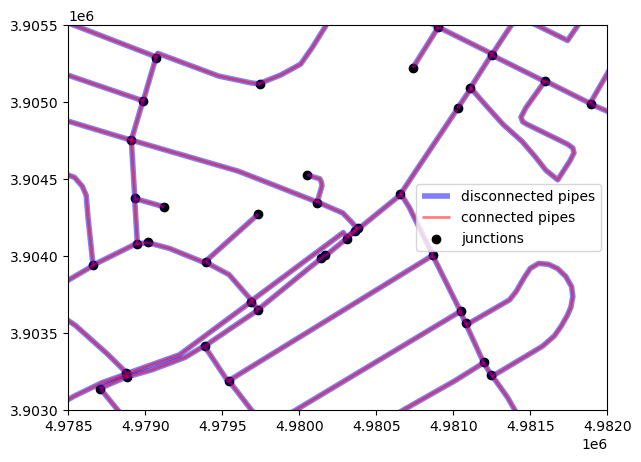

In [19]:
distance_threshold = 15.0 # ft, used to connect pipes

print('Number of diconnected pipes', diconnected_pipes.shape[0])
pipes, junctions = wntr.gis.geospatial.connect_lines(diconnected_pipes, distance_threshold)
print('Number of connected pipes', pipes.shape[0])
print(pipes.head())
print(junctions.head())

fig, ax = plt.subplots(figsize=(12,5))
diconnected_pipes.plot(color="b", linewidth=4, alpha=0.5, label='disconnected pipes', ax=ax)
pipes.plot(color="r", linewidth=2, alpha=0.5, label='connected pipes', ax=ax)
junctions.plot(color="k", label='junctions', ax=ax)
ax.legend()
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

### Check connectivity

In [20]:
junctions['elevation'] = 0.0
gis_data = wntr.gis.WaterNetworkGIS({"junctions": junctions,
                                     "pipes": pipes})
wn2_temp = wntr.network.from_gis(gis_data)
G = wn2_temp.to_graph()

uG = G.to_undirected()
assert nx.is_connected(uG)

print(nx.is_connected(uG))
print(nx.number_connected_components(uG))

True
1


### Assign elevation to junctions using a raster

In [21]:
junction_elevations = wntr.gis.sample_raster(junctions, elevation_data_file)
junctions["elevation"] = junction_elevations
print(junctions.head())

                             geometry   elevation
0     POINT (4971348.280 3905606.319)  188.063782
1     POINT (4972891.970 3905046.319)  197.130493
1618  POINT (4977116.192 3912077.244)  204.609299
392   POINT (4977022.775 3912151.501)  203.831848
4     POINT (4951831.196 3894540.658)  167.396561


### Snap reservoirs and tanks to the nearest junction

In [22]:
distance_threshold = 100.0 # ft, used to connect tanks and reservoirs

snap_reservoirs = wntr.gis.snap(reservoirs, junctions, distance_threshold)
print(reservoirs.head())
print(snap_reservoirs)

snap_tanks = wntr.gis.snap(tanks, junctions, distance_threshold)
print(tanks.head())
print(snap_tanks)

      initial_quality   base_head head_pattern_name  \
name                                                  
R-1               0.0  149.311004              None   

                             geometry  
name                                   
R-1   POINT (4978709.000 3915386.000)  
     node  snap_distance                         geometry
R-1  2262       3.027098  POINT (4978706.851 3915388.132)
       elevation  initial_quality  diameter  init_level  max_level  min_level  \
name                                                                            
T-1   196.940424              0.0   17.6784   25.563576  31.659576  24.039576   
T-2   207.439230              0.0   14.0208   25.732774  31.828770  25.732774   
T-3   217.703095              0.0   13.4112   30.708905  33.756905  27.051299   
T-4   220.580346              0.0   21.3360   29.355660  32.403654  21.735660   

      min_vol overflow vol_curve_name                         geometry  
name                                  

### Connect reservoirs and tanks with a pipe

In [23]:
def add_connector(snap_attribute, pipes):
    for name, row in snap_attribute.iterrows():
        pipe_crs = pipes.crs
        attributes = {'CV': 0, 
                      'diameter': 0.3, 
                      'status': 'Open',
                      'length': 1, 
                      'minor_loss': 0,
                      'roughness': 150,
                      'geometry': LineString([row['geometry'], row['geometry']]),
                      'start_node_name': row['node'],
                      'end_node_name': name}
        pipes.loc[name+'_connector'] = attributes
        pipes.set_crs(pipe_crs, inplace=True)
    return pipes
    
pipes = add_connector(snap_reservoirs, pipes)
pipes = add_connector(snap_tanks, pipes)
print(pipes.tail())

              CV  diameter status  length  minor_loss  roughness  \
name                                                               
R-1_connector  0       0.3   Open     1.0         0.0      150.0   
T-1_connector  0       0.3   Open     1.0         0.0      150.0   
T-2_connector  0       0.3   Open     1.0         0.0      150.0   
T-3_connector  0       0.3   Open     1.0         0.0      150.0   
T-4_connector  0       0.3   Open     1.0         0.0      150.0   

                                                        geometry  \
name                                                               
R-1_connector  LINESTRING (4978706.851 3915388.132, 4978706.8...   
T-1_connector  LINESTRING (4959472.582 3897654.880, 4959472.5...   
T-2_connector  LINESTRING (4972993.894 3900297.495, 4972993.8...   
T-3_connector  LINESTRING (4980613.762 3906673.733, 4980613.7...   
T-4_connector  LINESTRING (4988797.135 3907632.363, 4988797.1...   

              start_node_name end_node_name  


### Estimate demands from building size
- Estimate building demand from building area, normalized by the total demand in the system
- Snap building centroids to junctions 
- Assign a junction to each building

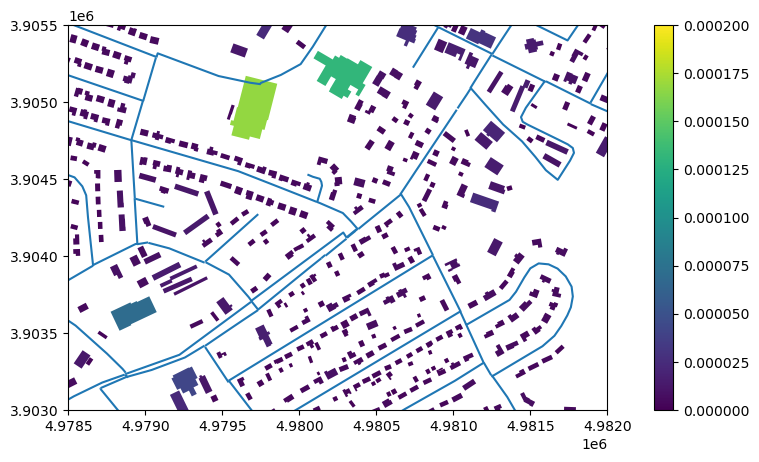

In [44]:
buildings["area"] = buildings.area
total_building_area = buildings["area"].sum()
buildings["base_demand"] = (buildings["area"] / total_building_area)*total_demand

fig, ax = plt.subplots(figsize=(12,5))
ax = buildings.plot(column='base_demand', vmin=0, vmax=0.0002, legend=True, ax=ax)
ax = pipes.plot(ax=ax)
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

In [25]:
distance_threshold = 1000.0 # ft, used to snap buildings to junctions

building_centroid = buildings.copy()
building_centroid.geometry = buildings.geometry.centroid
snap_buildings = wntr.gis.snap(building_centroid, junctions, distance_threshold)
buildings["junction"] = None
buildings.loc[snap_buildings.index, "junction"] = snap_buildings.loc[:, "node"]

print(buildings.head())
print(snap_buildings.head())

   release   capture_dates_range  \
0        2  9/24/2019-10/13/2019   
1        2  9/24/2019-10/13/2019   
2        2  9/24/2019-10/13/2019   
3        2  9/24/2019-10/13/2019   
4        2  9/24/2019-10/13/2019   

                                            geometry         area  \
0  POLYGON ((4992524.844 3912464.815, 4992539.528...   439.420921   
1  POLYGON ((4989555.767 3908142.487, 4989514.592...  1852.319947   
2  POLYGON ((4989136.078 3908331.500, 4989133.377...  1971.192177   
3  POLYGON ((4988542.497 3906794.824, 4988543.833...  1692.152025   
4  POLYGON ((4989379.408 3908656.559, 4989419.729...  1514.493614   

    base_demand junction  
0  9.102015e-07      275  
1  3.836832e-06      406  
2  4.083060e-06      406  
3  3.505066e-06     1578  
4  3.137070e-06      406  
   node  snap_distance                         geometry
0   275     314.401450  POINT (4992684.737 3912204.114)
1   406     514.799236  POINT (4989670.687 3908617.030)
2   406     618.390068  POINT (4989670

## Build the model

### Add geospatial data
Add junctions, tanks, reservoirs, and pipes.  Pumps are later to the water network model.

In [26]:
gis_data = wntr.gis.WaterNetworkGIS({"junctions": junctions,
                                     "tanks": tanks,
                                     "reservoirs": reservoirs,
                                     "pipes": pipes})
wn2 = wntr.network.from_gis(gis_data)

### Add pumps
- Snap disconnected pumps to pipes
- Break the pipe that is closest to each pump
- Determine pump flow direction, based on distance to the nearest reservoir
- Add the pump to the model

In [27]:
distance_threshold = 100.0 # ft used to snap pumps to pipes

snap_pumps = wntr.gis.snap(disconnected_pumps, pipes, distance_threshold)
print(disconnected_pumps.head())
print(snap_pumps.head())

         initial_status pump_type  base_speed        power pump_curve_name  \
name                                                                         
~@Pump-1         Closed     POWER         1.0  111854.9808            None   
~@Pump-2           Open     POWER         1.0   37284.9936            None   

         speed_pattern_name                         geometry  
name                                                          
~@Pump-1               None  POINT (4978752.040 3915150.000)  
~@Pump-2               None  POINT (4979020.220 3915339.000)  
           link  node  snap_distance  line_position  \
~@Pump-1  P-977  2263       3.027098       1.000000   
~@Pump-2  P-365   904       1.244492       0.000058   

                                 geometry  
~@Pump-1  POINT (4978749.891 3915152.132)  
~@Pump-2  POINT (4979020.914 3915337.967)  


In [28]:
# Compute distance to the nearest reservoirs (there is only 1 reservoir in ky4)
length = wn2.query_link_attribute('length')
G = wn2.to_graph(link_weight = length)
uG = G.to_undirected()
distance_to_reservoir = nx.multi_source_dijkstra_path_length(uG, wn2.reservoir_name_list, weight='weight')

In [29]:
# Break pipes and update the pumps dataframe
pumps = disconnected_pumps.copy()
for pump_name in disconnected_pumps.index:
    nearest_pipe = snap_pumps.loc[pump_name, 'link']
    pipe = wn2.get_link(nearest_pipe)
    # determine start and end node based on distance to the nearest reservoir
    distanceA = distance_to_reservoir[pipe.start_node_name]
    distanceB = distance_to_reservoir[pipe.end_node_name]
    start_node_name = pump_name+'A'
    end_node_name = pump_name+'B'
    if distanceA > distanceB:
        start_node_name = pump_name+'B'
        end_node_name = pump_name+'A'
    wn2 = wntr.morph.break_pipe(wn2, nearest_pipe, nearest_pipe+'_pump_connector', start_node_name, end_node_name)
    pumps['start_node_name'] = start_node_name
    pumps['end_node_name'] = end_node_name

In [30]:
# Add pumps (note that this could be done in the loop above with add_pump)
gis_data = wntr.gis.WaterNetworkGIS({"pumps": pumps})
wn2 = wntr.network.from_gis(gis_data, append=wn2)

### Add controls

In [31]:
line = "LINK ~@Pump-1 OPEN IF NODE T-3 BELOW  27.6606"  # 90.75 ft
wn2.add_control("Pump1_open", line)

line = "LINK ~@Pump-1 CLOSED IF NODE T-3 ABOVE  32.2326"  # 105.75 ft
wn2.add_control("Pump1_closed", line)

### Add demand pattern and base demand

In [32]:
multipliers = [
    0.33, 0.25, 0.209, 0.209, 0.259, 0.36,
    0.529, 0.91, 1.2, 1.299, 1.34, 1.34,
    1.32, 1.269, 1.25, 1.25, 1.279, 1.37,
    1.519, 1.7, 1.75, 1.669, 0.899, 0.479,
]
default_pattern_name = wn2.options.hydraulic.pattern
wn2.add_pattern(default_pattern_name, multipliers)

category = None
for i, row in buildings.iterrows():
    junction_name = buildings.loc[i, "junction"]
    if junction_name is None:
        continue
    base_demand = buildings.loc[i, "base_demand"]
    junction = wn2.get_node(junction_name)
    junction.demand_timeseries_list.append((base_demand, default_pattern_name, category))

### Add pump initial status

In [33]:
pump = wn2.get_link("~@Pump-1")
pump.initial_status = "Closed"

## Run a hydraulic simulation and compute metrics

In [34]:
sim = wntr.sim.EpanetSimulator(wn2)
results2 = sim.run_sim()
pressure2 = results2.node["pressure"].loc[0, :]
pressure2[pressure2<0] = 0 # remove negative pressure
aed2 = wntr.metrics.average_expected_demand(wn2)

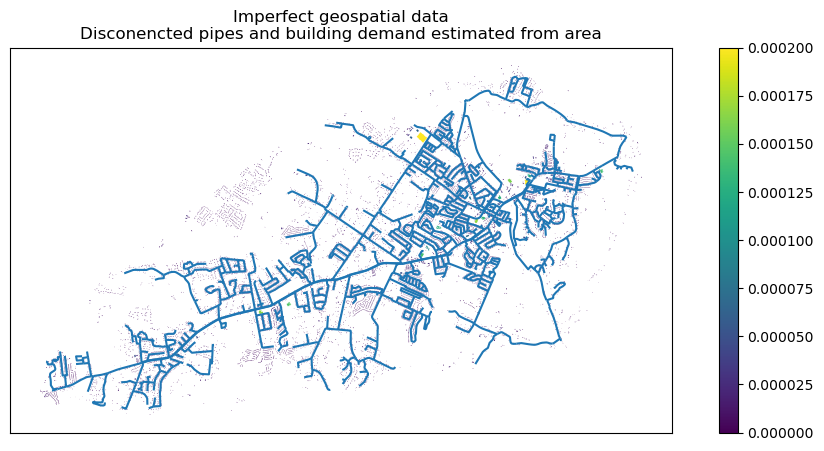

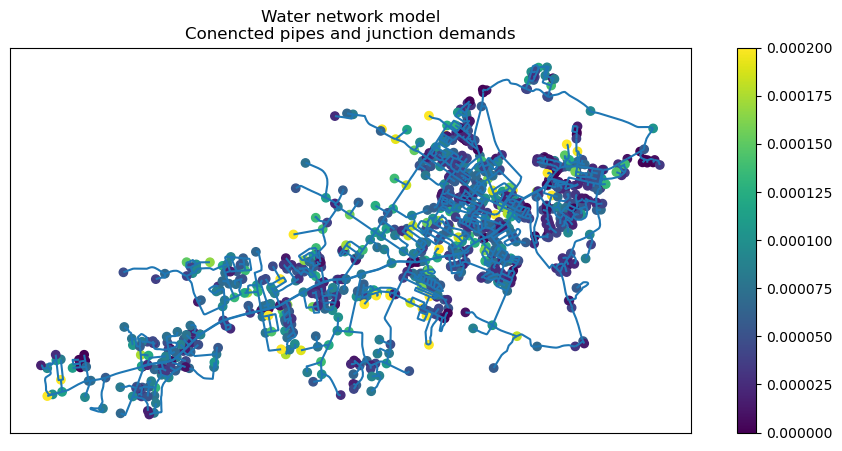

In [45]:
# Plot data and water network model
fig, ax = plt.subplots(figsize=(12,5))
ax = buildings.plot(column='base_demand', vmin=0, vmax=0.0002, legend=True, ax=ax)
ax = diconnected_pipes.plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
tmp = axes[0].set_xlim(zoom_coords[0])
tmp = axes[0].set_ylim(zoom_coords[1])
tmp = ax.set_title('Imperfect geospatial data\nDisconencted pipes and building demand estimated from area')

fig, ax = plt.subplots(figsize=(12,5))
junctions['aed2'] = aed2
ax = junctions.plot(column='aed2', vmin=0, vmax=0.0002, legend=True, ax=ax)
ax = pipes.plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
tmp = ax.set_xlim(zoom_coords[0])
tmp = axes[1].set_ylim(zoom_coords[1])
tmp = ax.set_title('Water network model\nConencted pipes and junction demands')

## Compare the base model to the model created from imperfect geospatial data
Compare number of components and the difference in average expected demand and pressure

Note that the wn0/wn1 comparisons won't work here because the models do not share the same link and node names. The difference of mean is used instead of the mean of the difference.

In [36]:
print(wn0.describe())
print(wn2.describe())

{'Nodes': 964, 'Links': 1158, 'Patterns': 3, 'Curves': 0, 'Sources': 0, 'Controls': 2}
{'Nodes': 965, 'Links': 1157, 'Patterns': 1, 'Curves': 0, 'Sources': 0, 'Controls': 2}


In [37]:
# Compute absolute difference in mean average expected demand and mean pressure
aed_diff2 = abs(aed0.mean() - aed2.mean())
pressure_diff2 = abs(pressure0.mean() - pressure2.mean())

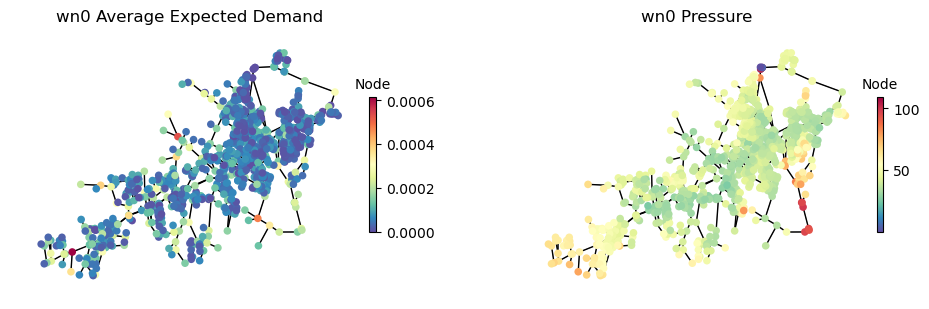

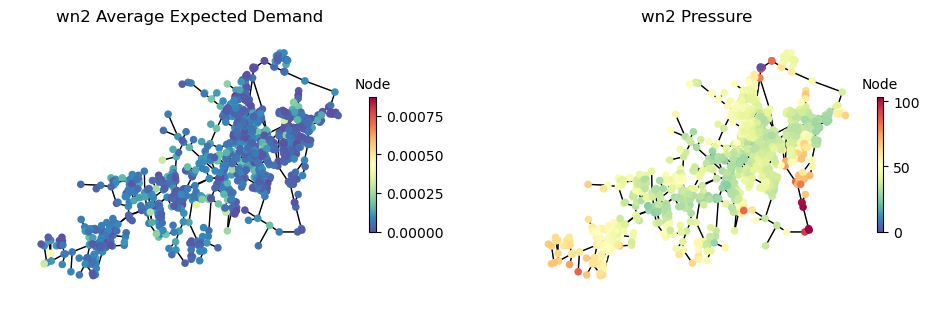

In [38]:
fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn0, node_attribute=aed0, node_size=30, title="wn0 Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn0, node_attribute=pressure0, node_size=30, title="wn0 Pressure", show_plot=False, ax=axes[1])

fig, axes = plt.subplots(1,2, figsize=(12,3.5))
ax = wntr.graphics.plot_network(wn2, node_attribute=aed2, node_size=30, title="wn2 Average Expected Demand", show_plot=False, ax=axes[0])
ax = wntr.graphics.plot_network(wn2, node_attribute=pressure2, node_size=30, title="wn2 Pressure", show_plot=False, ax=axes[1])

In [39]:
# Assert that difference in average expected demand and pressure is small
print(aed_diff2, pressure_diff2)
assert (aed_diff2 < 1e-3), "Average expected demand difference is greater that tolerance"
assert (pressure_diff2 < 0.2), "Pressure difference is greater that tolerance"

8.476564300064628e-06 0.19337845
